# A3: Project on complex networks
### Analyzing Spotify Data: Global Patterns of Musical Taste and Artist/Genre Clustering by Country
#### _By Saioa Elizondo, Marc Albesa and Maria Fité_
**Group Name:** A3L

**Objective:** Development of a Project in which you put into practice some of the knowledge acquired
during this course on Complex Networks.

**Kind of project:** Analysis. Obtain real data which can be put in terms of network(s),
and analyze the network(s) to answer any question or hypothesis
about them. It is not enough to calculate descriptors or communities,
you must try to answer relevant questions about the system's
functioning.

## 0. Preparing the enviroment

In [1]:
%pip install spotipy
%pip install cartopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Code to import the needed modules/packages to run the notebook
import os
import ast
import pandas as pd # dataframes
import numpy as np # Mathematical operations
import matplotlib.pyplot as plt # Reçpresentation
import random as random
import networkx as nx # Network tools
import spotipy
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from collections import Counter
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from spotipy.oauth2 import SpotifyClientCredentials

# Get workng directory
wd = os.getcwd()

## 1. Importing data and constructing the network
### 1.1. Defining playlist IDs

In [3]:
playlist_ids = {
    "Catalonia": "5IczcOjRojDGQmphylNgAk",  
    "Spain": "7tk0qdAQnySyJC5NIC46LL",  
    "Argentina": "7hoGYwZsVAzxSeVDbABqEs",  
    "Brazil": "2vUqKjPCtiJN4AL0jVuSiQ",  
    "Italy": "0XxpxWDgSajIJubwjSG5p4",
    "France": "4Y9F9p3eOVnAnBdnWXgf3W",  
    "USA": "53aDM9BNWGgdbskDrMDBzd",  
    "Colombia": "3Oe6dTHiFHtJGu6CgIXvw2",  
    "UK": "0ZrNYP9GlN7C89nRcmb0ET", 
    "Ecuador": "0gb959SjjZBGj9tsOHpAjU",  
    "Mexico": "002EH6cGKQCzSl5XVJhub6", 
    "Chile": "7sEuTk63hXvwOyaku7G9oR", 
    "Russia": "0UBqxjbJs3nhI2Wexpd0tN", 
    "Germany": "0bk2WTv51p9vT5aplcHz3f", 
    "Portugal": "4LObto7Z2gRAH4o5H86EqQ", 
    "South Korea": "6Ah4okZFJJnDBjUiRhx0Uu",  
    "Venezuela": "6BRogt5aan10pDoueAcWgo",  
    "Morocco": "2zA1uaGEDg75UdcjZJER4e", 
    "Romania": "4jbgA8bDbQSDAjLAFKkTH9", 
    "Sweden": "0COXLs3GcoSx80UrlvXUUy",  
    "India": "4pbVk8P4zK0cL45qT6PgB1", 
    "Uruguay": "61HbuFG0J1Mc7SkEugwzYt",
    "Japan": "65M6poLBwAdYs0TD7qemPk",
    "Ireland": "4nmlpg46HQ1ctO6pbTAI1T", 
    "Dominican Republic": "4Krj4NmrOoWIALF3q3yanF",
    "Philippines": "5Ut79yzqJcHoOkUVJIqLWg", 
    "Indonesia": "5OazJo0Grq2aP6LsqP8cFP",
    "Austria":"4fxedQjEpyOwCox6Ug5PBi", 
    "Peru":"2dxdatUmtaLzJy4lAqPOl0",
    "Australia": "79Mjnq7qvaotdus0eXoYvy", 
}

### 1.2. Building the dataset

In [4]:
# Set up credentials
from spotipy.oauth2 import SpotifyOAuth

client_id = '19107210277541c8a31c434e1d5d58c5'
client_secret = 'bf0216ea58b1471a976b1179aec337c5'  
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri='http://localhost:8888/callbackif',
    scope="playlist-read-private playlist-read-collaborative"
))

# Initialize empty dataframe
dataframe = pd.DataFrame()

# Fetch playlist tracks
for country, playlist_id in playlist_ids.items():
    print(f"Fetching playlist {playlist_id} for {country}")

    # Retrieve playlist items
    try:
        playlist_tracks = sp.playlist_items(playlist_id, market="global")
    except Exception as e:
        print(f"Error fetching playlist {playlist_id}: {e}")
        continue

    # Create and initialize dataframe entry
    country_artists = dict()
    country_artists = {"Country": country}

    for index, item in enumerate(playlist_tracks['items']):
        track = item["track"]

        # Fetch track stats
        Position = index + 1
        Artist = track["artists"][0]["name"]
        Album = track["album"]
        Popularity = track["popularity"]

        # Compute popularity score (weight)
        popularity_score = (51-Position)
        
        # Check if the artist already in the country top50
        if Artist in country_artists.keys():
            country_artists[Artist] += popularity_score
        else: # Add as a new row
            country_artists[Artist] = popularity_score

    # Add the dictionary as a new row
    dataframe = pd.concat([dataframe, pd.DataFrame([country_artists])], ignore_index=True)

# Print DataFrame
dataframe

Fetching playlist 5IczcOjRojDGQmphylNgAk for Catalonia
Fetching playlist 7tk0qdAQnySyJC5NIC46LL for Spain
Fetching playlist 7hoGYwZsVAzxSeVDbABqEs for Argentina
Fetching playlist 2vUqKjPCtiJN4AL0jVuSiQ for Brazil
Fetching playlist 0XxpxWDgSajIJubwjSG5p4 for Italy
Fetching playlist 4Y9F9p3eOVnAnBdnWXgf3W for France
Fetching playlist 53aDM9BNWGgdbskDrMDBzd for USA
Fetching playlist 3Oe6dTHiFHtJGu6CgIXvw2 for Colombia
Fetching playlist 0ZrNYP9GlN7C89nRcmb0ET for UK
Fetching playlist 0gb959SjjZBGj9tsOHpAjU for Ecuador
Fetching playlist 002EH6cGKQCzSl5XVJhub6 for Mexico
Fetching playlist 7sEuTk63hXvwOyaku7G9oR for Chile
Fetching playlist 0UBqxjbJs3nhI2Wexpd0tN for Russia
Fetching playlist 0bk2WTv51p9vT5aplcHz3f for Germany
Fetching playlist 4LObto7Z2gRAH4o5H86EqQ for Portugal
Fetching playlist 6Ah4okZFJJnDBjUiRhx0Uu for South Korea
Fetching playlist 6BRogt5aan10pDoueAcWgo for Venezuela
Fetching playlist 2zA1uaGEDg75UdcjZJER4e for Morocco
Fetching playlist 4jbgA8bDbQSDAjLAFKkTH9 for Romania


,Country,Alfred García,Oques Grasses,Figa Flawas,Lal'Ba,Els Amics De Les Arts,JULS,Miki Núñez,Sexenni,Buhos,...,La Única Tropical,Pascal,Trueno,Milo j,Vance Joy,Luke Combs,Taylor Swift,Royel Otis,The Kid LAROI,The Goo Goo Dolls
0,Catalonia,80.0,49.0,96.0,47.0,46.0,45.0,44.0,43.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Ecuador,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Select columns with more than 1 non-NaN row
filtered_columns = dataframe.loc[:, dataframe.count() > 1]
print(list(filtered_columns.columns))

['Country', 'Alleh', 'Danny Ocean', 'Myke Towers', 'Clarent', 'KAROL G', 'Yan Block', 'Beéle', 'Blessd', 'Bizarrap', 'Rels B', 'Omar Courtz', 'Rauw Alejandro', 'ROSÉ', 'Bad Bunny', 'Lady Gaga', 'Feid', 'ROA', 'Kapo', 'FloyyMenor', 'Duki', 'Gracie Abrams', 'Shakira', 'La T y La M', 'Gordo', 'Jombriel', 'Tiago PZK', 'Renzo ED', 'Big One', 'Los Ángeles Azules', 'Luck Ra', 'Salastkbron', 'Valentino Merlo', 'Emilia', 'Emanero', 'ECKO', 'King Savagge', "Hernan y La Champion's Liga", 'Paulo Londra', 'No Te Va Gustar', 'Nicki Nicole', 'Standly', 'DJ Tao', 'Lucky Brown', 'Oruam', 'Nilo', 'MC Tuto', 'Léo Foguete', 'J. Eskine', 'MC LUUKY', 'DJ TOPO', 'Mc Negão Original', 'MC Marks', 'MC Cebezinho', 'Supernova Ent', 'PEDRO SAMPAIO', 'Billie Eilish', 'Arcane', 'Jul', 'Teddy Swims', 'Lola Young', 'Macklemore', 'Alex Warren', 'David Guetta', 'Benson Boone', 'Sabrina Carpenter', 'Kendrick Lamar', 'Tyler, The Creator', 'Gigi Perez', 'The Weeknd', 'Chappell Roan', 'Jimin', 'SZA', 'Post Malone', 'Shabooz

In [6]:
# Save DataFrame to a CSV file
dataframe.to_csv(os.path.join(wd, "spotify_global_data.csv"), index=False)  # Set index=False to exclude the index column
print("DataFrame saved to 'spotify_global_data.csv'.")

# Read the CSV file and load it into a new DataFrame
spotify_global_data = pd.read_csv(os.path.join(wd, "spotify_global_data.csv"))
print("DataFrame loaded from 'spotify_global_data.csv':")

DataFrame saved to 'spotify_global_data.csv'.
DataFrame loaded from 'spotify_global_data.csv':


### 1.3. Converting the dataframe to a NetworkX bipartite graph

In [7]:
# Extract node types
country_nodes = list(spotify_global_data.iloc[:, 0])  # First column represents nodes of Type A
artist_nodes = list(spotify_global_data.columns[1:])  # Remaining columns represent nodes of Type B

# Initialize a bipartite graph
B = nx.Graph()

# Add nodes of Type A
B.add_nodes_from(country_nodes, bipartite=0)  # Bipartite group 0

# Add nodes of Type B
B.add_nodes_from(artist_nodes, bipartite=1)  # Bipartite group 1

# Add edges with weights (skip NaN values)
for index, row in spotify_global_data.iterrows():
    node_a = row.iloc[0]  # First column (node from Type A)
    for node_b in artist_nodes:
        weight = row[node_b]
        if pd.notna(weight):  # Add edge if weight is not NaN
            B.add_edge(node_a, node_b, weight=weight)

# Output results
print("Nodes in the bipartite graph:")
print(B.nodes(data=True))
print("\nEdges in the bipartite graph:")
print(B.edges(data=True))

Nodes in the bipartite graph:
[('Catalonia', {'bipartite': 0}), ('Spain', {'bipartite': 0}), ('Argentina', {'bipartite': 0}), ('Brazil', {'bipartite': 0}), ('Italy', {'bipartite': 0}), ('France', {'bipartite': 0}), ('USA', {'bipartite': 0}), ('Colombia', {'bipartite': 0}), ('UK', {'bipartite': 0}), ('Ecuador', {'bipartite': 0}), ('Mexico', {'bipartite': 0}), ('Chile', {'bipartite': 0}), ('Russia', {'bipartite': 0}), ('Germany', {'bipartite': 0}), ('Portugal', {'bipartite': 0}), ('South Korea', {'bipartite': 0}), ('Venezuela', {'bipartite': 0}), ('Morocco', {'bipartite': 0}), ('Romania', {'bipartite': 0}), ('Sweden', {'bipartite': 0}), ('India', {'bipartite': 0}), ('Uruguay', {'bipartite': 0}), ('Japan', {'bipartite': 0}), ('Ireland', {'bipartite': 0}), ('Dominican Republic', {'bipartite': 0}), ('Philippines', {'bipartite': 0}), ('Indonesia', {'bipartite': 0}), ('Austria', {'bipartite': 0}), ('Peru', {'bipartite': 0}), ('Australia', {'bipartite': 0}), ('Alfred García', {'bipartite': 1})

## 2. Visualizing the network

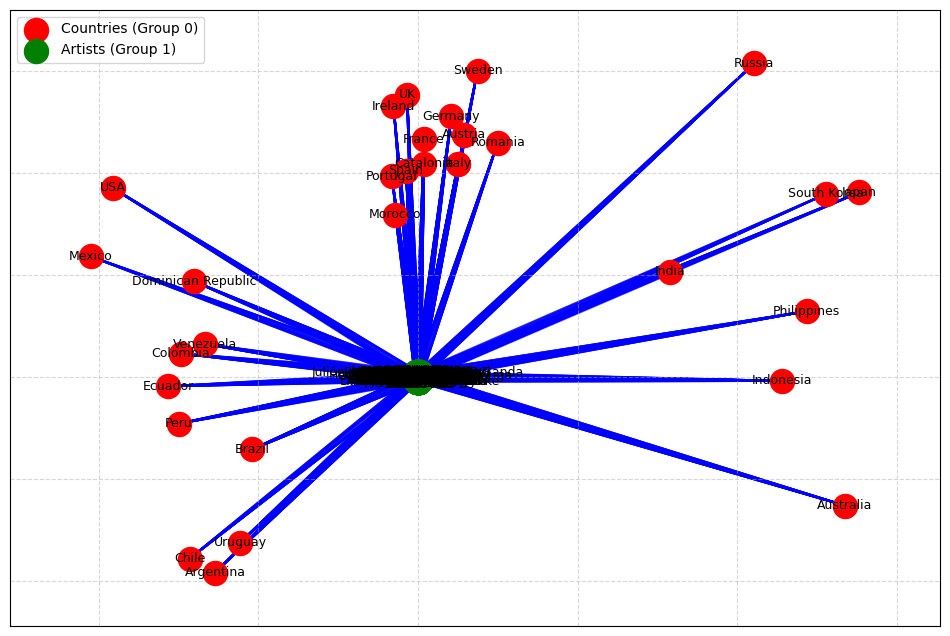

In [ ]:
# Artists are in group 1, and countries are in group 0
country_positions = {
    "Catalonia": (1.8677, 41.8205),  # Longitude, Latitude
    "Spain": (-3.7492, 40.4637),
    "Argentina": (-63.6167, -38.4161),
    "Brazil": (-51.9253, -14.2350),
    "Italy": (12.5674, 41.8719),
    "France": (1.8883, 46.6034),
    "USA": (-95.7129, 37.0902),
    "Colombia": (-74.2973, 4.5709),
    "UK": (-3.4360, 55.3781),
    "Ecuador": (-78.1834, -1.8312),
    "Mexico": (-102.5528, 23.6345),
    "Chile": (-71.5430, -35.6751),
    "Russia": (105.3188, 61.5240),
    "Germany": (10.4515, 51.1657),
    "Portugal": (-8.2245, 39.3999),
    "South Korea": (127.7669, 35.9078),
    "Venezuela": (-66.5897, 6.4238),
    "Morocco": (-7.0926, 31.7917),
    "Romania": (24.9668, 45.9432),
    "Sweden": (18.6435, 60.1282),
    "India": (78.9629, 20.5937),
    "Uruguay": (-55.7658, -32.5228),
    "Japan": (138.2529, 36.2048),
    "Ireland": (-7.6921, 53.1424),
    "Dominican Republic": (-70.1627, 18.7357),
    "Philippines": (121.7740, 12.8797),
    "Indonesia": (113.9213, -0.7893),
    "Austria": (14.5501, 47.5162),
    "Peru": (-75.0152, -9.1900),
    "Australia": (133.7751, -25.2744),
}

# Filter country and artist nodes
country_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == 0]
artist_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == 1]

# Ensure positions for countries are fixed
country_positions_fixed = {node: country_positions[node] for node in country_nodes}

# Compute dynamic positions for artists
artist_positions_dynamic = nx.spring_layout(B.subgraph(artist_nodes))  # Dynamic layout for artists

# Combine fixed and dynamic positions
combined_positions = {**country_positions_fixed, **artist_positions_dynamic}

# Plot the bipartite graph
plt.figure(figsize=(12, 8), facecolor="white")  # Set the figure background color
nx.draw_networkx_edges(B, combined_positions, edge_color="blue", alpha=0.5, width=1.5)

# Draw country nodes (Group 0)
nx.draw_networkx_nodes(
    B, combined_positions, nodelist=country_nodes, node_size=300, node_color="red", label="Countries (Group 0)"
)

# Draw artist nodes (Group 1)
nx.draw_networkx_nodes(
    B, combined_positions, nodelist=artist_nodes, node_size=300, node_color="green", label="Artists (Group 1)"
)

# Draw labels
nx.draw_networkx_labels(B, combined_positions, font_size=9, font_color="black")

# Customize plot
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
# Example bipartite graph
B = nx.Graph()

# Add nodes for two groups
group_0 = ["A1", "A2", "A3"]  # Type A nodes
group_1 = ["B1", "B2", "B3"]  # Type B nodes
B.add_nodes_from(group_0, bipartite=0)
B.add_nodes_from(group_1, bipartite=1)

# Add edges
B.add_edges_from([
    ("A1", "B1"), ("A1", "B2"),
    ("A2", "B2"), ("A3", "B3")
])

# Get the positions for bipartite graph layout
pos = nx.bipartite_layout(B, nodes=group_0)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(B, pos, with_labels=True, node_color="lightblue", node_size=2000, edge_color="gray", font_size=10, font_weight="bold")
plt.title("Bipartite Graph Visualization")
plt.show()

In [ ]:
# Reading csv files
edges = pd.read_csv(os.path.join(wd, "network", "edges.csv"))
nodes = pd.read_csv(os.path.join(wd, "network", "nodes.csv"))

# Defining directed graph
G = nx.DiGraph()

# Adding nodes
nodenames = nodes["# index"].values
    
for node in nodenames:
    G.add_node(node, label=node)

# Adding edges
for i in range(len(edges)):
    node1 = edges["# source"][i]
    node2 = edges[" target"][i]
    regulation = int(edges[" regulation_type"][i])
    if regulation == 1:
        G.add_edge(node1,node2, reg_type = "1")
    elif regulation == 2:
        G.add_edge(node2,node1, reg_type = "2")
    elif regulation == 3:
        G.add_edge(node1,node2, reg_type = "3")
        G.add_edge(node2,node1, reg_type = "3")

# If the network is not (weakly) connected, select the largest connected component (LCC) 
# for the rest of the analysis. This LCC must have at least 200 nodes.

# Get all weakly connected components
weak_components = list(nx.weakly_connected_components(G)) 

# Find the largest weakly connected component (LCC)
largest_weak_component = max(weak_components, key=len)
G_lcc = G.subgraph(largest_weak_component).copy()

# Updating nodes and edges for the lcc
nodes_lcc = nodes[ nodes["# index"].isin(G_lcc.nodes())]
edges_lcc = edges[edges['# source'].isin(G_lcc.nodes()) & edges[' target'].isin(G_lcc.nodes())]

# Check connectivity of the largest weakly connected component
print("Largest connected component is weakly connected:",nx.is_weakly_connected(G_lcc))

# Check number of nodes is at least 200
print('The number of nodes is:', G_lcc.number_of_nodes())

In [ ]:
df.to_csv('spotify_top50_data.csv', index=False)

In [ ]:
df.to_csv('spotify_top50_data.csv', index=False)